## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
!pip install pyldavis
!pip install --upgrade --force-reinstall numpy gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_versi

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

#gensim for LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# LDA plotting
import pyLDAvis
import pyLDAvis.gensim
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [2]:
pd.set_option('display.max_colwidth', None)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
from google.colab import files

# This will prompt you to upload the file from your local system
uploaded = files.upload()

Saving complaints_ticket_classification.json to complaints_ticket_classification.json


In [4]:
# Opening JSON file
f = open('complaints_ticket_classification.json', 'r') # Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df = pd.json_normalize(data, sep='_')
df.head()

,_index,_type,_id,_score,_source_tags,_source_zip_code,_source_complaint_id,_source_issue,_source_date_received,_source_state,...,_source_company_response,_source_company,_source_submitted_via,_source_date_sent_to_company,_source_company_public_response,_source_sub_product,_source_timely,_source_complaint_what_happened,_source_sub_issue,_source_consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source_tags                       10900 non-null  object 
 5   _source_zip_code                   71556 non-null  object 
 6   _source_complaint_id               78313 non-null  object 
 7   _source_issue                      78313 non-null  object 
 8   _source_date_received              78313 non-null  object 
 9   _source_state                      76322 non-null  object 
 10  _source_consumer_disputed          78313 non-null  object 
 11  _source_product                    78313 non-null  obj

In [6]:
empty_mask = df['_source_complaint_what_happened'] == ''
empty_mask.sum()

57241

In [7]:
df[empty_mask].head()

,_index,_type,_id,_score,_source_tags,_source_zip_code,_source_complaint_id,_source_issue,_source_date_received,_source_state,...,_source_company_response,_source_company,_source_submitted_via,_source_date_sent_to_company,_source_company_public_response,_source_sub_product,_source_timely,_source_complaint_what_happened,_source_sub_issue,_source_consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A


In [8]:
print(df['_source_sub_issue'].value_counts())
print(df['_source_sub_product'].value_counts())
print(df['_source_consumer_consent_provided'].value_counts())

_source_sub_issue
Credit card company isn't resolving a dispute about a purchase on your statement    2904
Deposits and withdrawals                                                            2759
Company closed your account                                                         2020
Problem using a debit or ATM card                                                   1613
Card was charged for something you did not purchase with the card                   1056
                                                                                    ... 
Problem with additional add-on products or services purchased with the loan            1
Receiving unwanted marketing/advertising                                               1
Report shared with employer w/o consent                                                1
Problem cancelling or closing account                                                  1
Account terms and changes                                                              1
Nam

In [9]:
df.nunique()

,0
_index,1
_type,1
_id,78313
_score,1
_source_tags,3
_source_zip_code,9442
_source_complaint_id,78313
_source_issue,154
_source_date_received,3444
_source_state,62


##### Based on the above check, for Topic Modeling Purpose, the columns _source_complaint_what_happened will be used. There can be additional metrics which can be leveraged later for classification task later. Otherwise, majorly, the columns id or source_complaint_id (same) and complaint column is required

In [10]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source_tags', '_source_zip_code',
       '_source_complaint_id', '_source_issue', '_source_date_received',
       '_source_state', '_source_consumer_disputed', '_source_product',
       '_source_company_response', '_source_company', '_source_submitted_via',
       '_source_date_sent_to_company', '_source_company_public_response',
       '_source_sub_product', '_source_timely',
       '_source_complaint_what_happened', '_source_sub_issue',
       '_source_consumer_consent_provided'],
      dtype='object')

In [11]:
df.head(2)

,_index,_type,_id,_score,_source_tags,_source_zip_code,_source_complaint_id,_source_issue,_source_date_received,_source_state,...,_source_company_response,_source_company,_source_submitted_via,_source_date_sent_to_company,_source_company_public_response,_source_sub_product,_source_timely,_source_complaint_what_happened,_source_sub_issue,_source_consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided


In [12]:
#Assign new column names
df.columns = df.columns.str.replace('_source_', '', regex=False).str.lstrip('_')
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [13]:
# Taking only relevant columns
df = df[['id', 'complaint_what_happened']]
df.columns = ['complaint_id', 'complaint']
df.head()

,complaint_id,complaint
0,3211475,
1,3229299,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.
2,3199379,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.
3,2673060,
4,3203545,


In [14]:
#Assign nan in place of blanks in the complaints column
df['complaint'].replace('', np.nan, inplace=True)

<ipython-input-14-625898619c03>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [15]:
#Remove all rows where complaints column is nan
print('Before Filtering for nan: ', df.shape)
df = df[df['complaint'].notna()]
print('After filtering for nan; ', df.shape)


Before Filtering for nan:  (78313, 2)
After filtering for nan;  (21072, 2)


In [16]:
# Storing the ids separately
df_id = df[['complaint_id']]

# dataframe for complaints which will be taken forward for preprocessing and topic modeling
df_complaints = df[['complaint']]
print('Checkng shape ', df_complaints.shape)
df_complaints.head(3)

Checkng shape  (21072, 1)


,complaint
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant."


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [17]:
## Defining everything in a class and then calling each of it for the next steps
class TextCleaner:
    def __init__(self, df, column):
        self.df = df.copy()
        self.column = column

    def to_lowercase(self):
        self.df[self.column] = self.df[self.column].str.lower()
        return self.df

    def remove_square_brackets(self):
        self.df[self.column] = self.df[self.column].str.replace(r'\[.*?\]', '', regex=True)
        return self.df

    def remove_punctuation(self):
        self.df[self.column] = self.df[self.column].str.translate(str.maketrans('', '', string.punctuation))
        return self.df

    def remove_words_with_numbers(self):
        self.df[self.column] = self.df[self.column].apply(
            lambda x: ' '.join(word for word in x.split() if not any(char.isdigit() for char in word))
        )
        return self.df

    def remove_encrypted_patterns(self):
        # Remove sequences of 2 or more Xs, possibly separated by spaces, slashes, or dashes
        pattern = r'\b(?:x[\s\/-]?){2,}\b'
        self.df[self.column] = self.df[self.column].str.replace(pattern, '', regex=True)
        return self.df

In [18]:
# Write your function here to clean the text and remove all the unnecessary elements.
cleaner = TextCleaner(df_complaints, 'complaint')

cleaner.to_lowercase()
cleaner.remove_square_brackets()
cleaner.remove_punctuation()
cleaner.remove_words_with_numbers()
cleaner.remove_encrypted_patterns()


df_pre_cleaned = cleaner.df
print(df_pre_cleaned.shape)
df_pre_cleaned.head(3)

(21072, 1)


,complaint
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant


In [19]:
#Write your function to Lemmatize the texts
def lemmatize_and_filter_nouns(df, column):
    """
    Lemmatizes text and keeps only singular nouns (POS tag == 'NN')
    """
    def process(text):
        doc = nlp(text)
        # Keep only lemmatized words with POS tag 'NN'
        return ' '.join([token.lemma_ for token in doc])

    df[column + '_nn_lemmatized'] = df[column].apply(process)
    return df

In [20]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = lemmatize_and_filter_nouns(df_pre_cleaned, 'complaint')
print(df_clean.shape)

(21072, 2)


In [21]:
df_clean

,complaint,complaint_nn_lemmatized
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account thank in advance for your help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead I
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not state why I ask for more information about the offer and she explain that even if I have be approve the credit offer only get apply after the first account statement and could not be use to purchase the 

In [22]:
#Write your function to extract the POS tags

def pos_tag(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if token.tag_ == 'NN'])

print(df_clean.shape)
df_clean["complaint_POS_removed"] =  df_clean["complaint_nn_lemmatized"].apply(pos_tag) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
print(df_clean.shape)

(21072, 2)
(21072, 3)


In [23]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,complaint_nn_lemmatized,complaint_POS_removed
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account thank in advance for your help,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead I,card agent anniversary date agent information order account change anniversary date consent recording agent mislead
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact and be refer to chase bank I then immediately contact chase bank within no

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




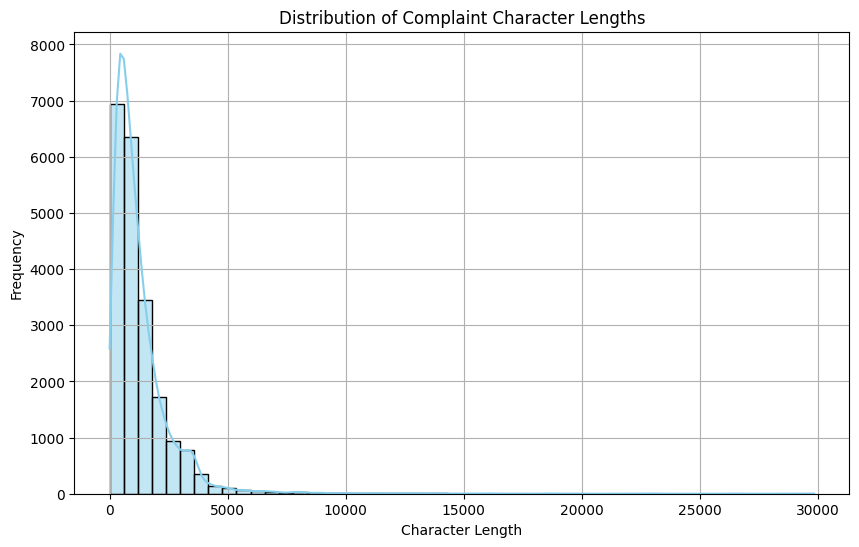

In [24]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_length'] = df_clean['complaint'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(df_clean['complaint_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Complaint Character Lengths')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

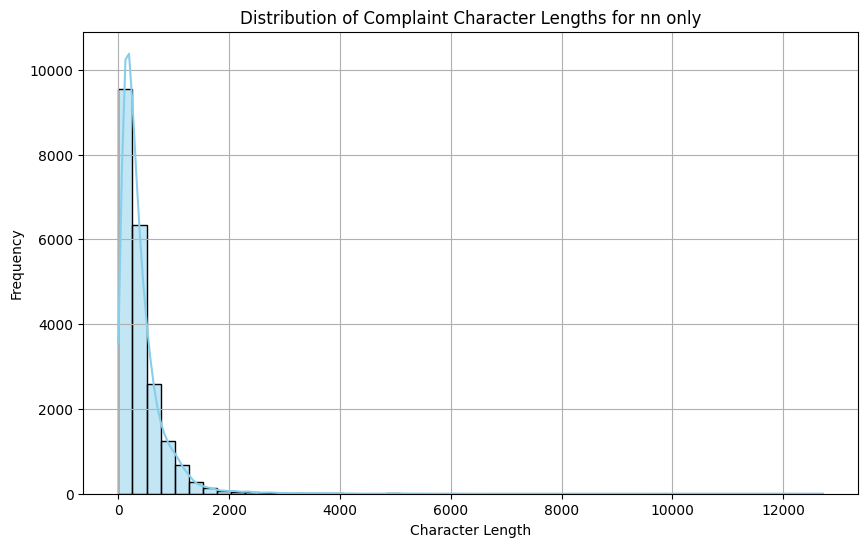

In [25]:
df_clean['complaint_length_nn_only'] = df_clean['complaint_POS_removed'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(df_clean['complaint_length_nn_only'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Complaint Character Lengths for nn only')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

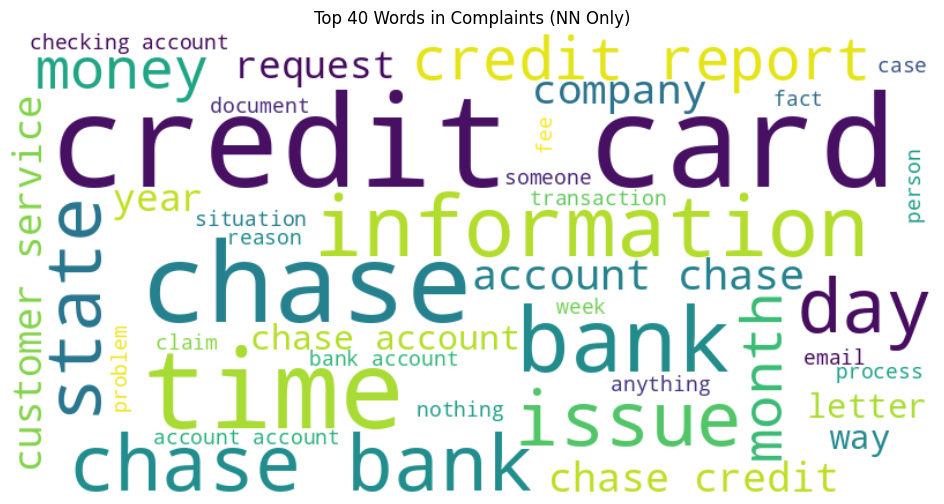

In [26]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud


text = ' '.join(df_clean['complaint_POS_removed'].dropna().tolist())


wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=40,  # Top 40 words
    colormap='viridis'
).generate(text)


plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 40 Words in Complaints (NN Only)')
plt.show()

In [27]:
#Removing -PRON- from the text corpus
print(df_clean.shape)
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
print(df_clean.shape)

(21072, 5)
(21072, 6)


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(df, column, ngram=1, top_n=30):
    """
    Function to extract and print top n-grams (unigram, bigram, trigram) from a given DataFrame column.

    Args:
    df : pandas DataFrame
    column : str - the name of the column containing text
    ngram : int - 1 for unigram, 2 for bigram, 3 for trigram
    top_n : int - number of top n-grams to return

    Returns:
    pandas DataFrame with top n-grams and their frequencies
    """
    # Drop NaNs and convert to list
    text_data = df[column].dropna().tolist()

    # Create CountVectorizer
    vectorizer = CountVectorizer(ngram_range=(ngram, ngram))
    X = vectorizer.fit_transform(text_data)

    # Sum over columns to get ngram frequencies
    sum_words = X.sum(axis=0)

    # Get ngram frequency dictionary
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

    # Sort and convert to DataFrame
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_ngrams_df = pd.DataFrame(sorted_words[:top_n], columns=[f'{ngram}-gram', 'Frequency'])

    return top_ngrams_df

In [29]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
top_unigrams = get_top_ngrams(df_clean, 'Complaint_clean', ngram=1)
top_unigrams.head(30)

,1-gram,Frequency
0,chase,61427
1,account,47782
2,credit,33558
3,card,30371
4,bank,22441
5,payment,21159
6,time,16025
7,charge,14784
8,day,12956
9,money,11940


In [30]:
#Print the top 10 words in the unigram frequency
top_unigrams['1-gram'].head(10)

,1-gram
0,chase
1,account
2,credit
3,card
4,bank
5,payment
6,time
7,charge
8,day
9,money


In [31]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
top_bigrams = get_top_ngrams(df_clean, 'Complaint_clean', ngram=2)
top_bigrams.head(30)

,2-gram,Frequency
0,credit card,12864
1,chase bank,4364
2,credit report,3961
3,account chase,3491
4,chase credit,3173
5,customer service,3080
6,chase account,2839
7,checking account,2528
8,bank account,2483
9,account account,2324


In [32]:
#Print the top 10 words in the bigram frequency
top_bigrams['2-gram'].head(10)

,2-gram
0,credit card
1,chase bank
2,credit report
3,account chase
4,chase credit
5,customer service
6,chase account
7,checking account
8,bank account
9,account account


In [33]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_trigrams = get_top_ngrams(df_clean, 'Complaint_clean', ngram=3)
top_trigrams.head(30)

,3-gram,Frequency
0,chase credit card,2150
1,credit card account,1081
2,credit card company,988
3,credit card chase,825
4,chase customer service,616
5,inquiry credit report,515
6,credit card credit,485
7,chase bank account,456
8,account credit card,426
9,charge credit card,402


In [34]:
#Print the top 10 words in the trigram frequency
top_trigrams['3-gram'].head(10)

,3-gram
0,chase credit card
1,credit card account
2,credit card company
3,credit card chase
4,chase customer service
5,inquiry credit report
6,credit card credit
7,chase bank account
8,account credit card
9,charge credit card


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
# df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

### This is already performed at the very top as it was observed during the EDA phase

In [35]:
#All masked texts has been removed
print(df_clean.shape)
df_clean

(21072, 6)


,complaint,complaint_nn_lemmatized,complaint_POS_removed,complaint_length,complaint_length_nn_only,Complaint_clean
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account thank in advance for your help,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account advance help,439,133,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead I,card agent anniversary date agent information order account change anniversary date consent recording agent mislead,296,115,card agent anniversary date agent information order account change anniversary date consent recording agent mislead
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant,209,80,chase card report application identity consent service credit identity applicant
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to p

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [36]:
#Write your code here to initialise the TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])

feature_names = tfidf_vectorizer.get_feature_names_out()
print(tfidf.shape)

(21072, 7002)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [37]:
pd.set_option('display.max_columns', None)

In [38]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=feature_names)
print(tfidf_df.shape)
tfidf_df.head()

(21072, 7002)


aa  aarp  abandonment  abatement  abbreviation  abet  abide  ability  \
0  0.0   0.0          0.0        0.0           0.0   0.0    0.0      0.0   
1  0.0   0.0          0.0        0.0           0.0   0.0    0.0      0.0   
2  0.0   0.0          0.0        0.0           0.0   0.0    0.0      0.0   
3  0.0   0.0          0.0        0.0           0.0   0.0    0.0      0.0   
4  0.0   0.0          0.0        0.0           0.0   0.0    0.0      0.0   

   abovementione  abovereference  absence  absent  absolve  absurdity  \
0            0.0             0.0      0.0     0.0      0.0        0.0   
1            0.0             0.0      0.0     0.0      0.0        0.0   
2            0.0             0.0      0.0     0.0      0.0        0.0   
3            0.0             0.0      0.0     0.0      0.0        0.0   
4            0.0             0.0      0.0     0.0      0.0        0.0   

   abundance  abuse  abuser   ac  acc  acccount  acceleration  accent  accept  \
0        0.0    0.0     0.0  0.0  0.0       0.0           0.0     0.0     0.0   
1        0.0    0.0     0.0  0.0  0.0       0.0           0.0     0.0     0.0   
2        0.0    0.0     0.0  0.0  0.0       0.0           0.0     0.0     0.0   
3        0.0    0.0     0.0  0.0  0.0       0.0           0.0     0.0     0.0   
4        0.0    0.0     0.0  0.0  0.0       0.0           0.0     0.0     0.0   

   acceptance  access  accessibility  accessory  accident  accidental  \
0         0.0     0.0            0.0        0.0       0.0         0.0   
1         0.0     0.0            0.0        0.0       0.0         0.0   
2         0.0     0.0            0.0        0.0       0.0         0.0   
3         0.0     0.0            0.0        0.0       0.0         0.0   
4         0.0     0.0            0.0        0.0       0.0         0.0   

   accommodation  accomodation  accompany  accomplice  accont  accord  \
0            0.0           0.0        0.0         0.0     0.0     0.0   
1            0.0           0.0        0.0         0.0     0.0     0.0   
2            0.0           0.0        0.0         0.0     0.0     0.0   
3            0.0           0.0        0.0         0.0     0.0     0.0   
4            0.0           0.0        0.0         0.0     0.0     0.0   

   accordance  accou  accouint  accoun   account  accountability  accountand  \
0         0.0    0.0       0.0     0.0  0.088077             0.0         0.0   
1         0.0    0.0       0.0     0.0  0.066822             0.0         0.0   
2         0.0    0.0       0.0     0.0  0.000000             0.0         0.0   
3         0.0    0.0       0.0     0.0  0.118471             0.0         0.0   
4         0.0    0.0       0.0     0.0  0.130285             0.0         0.0   

   accountant  accountbalance  accountchase  accountfunde  accountholder  \
0         0.0             0.0           0.0           0.0            0.0   
1         0.0             0.0           0.0           0.0            0.0   
2         0.0             0.0           0.0           0.0            0.0   
3         0.0             0.0           0.0           0.0            0.0   
4         0.0             0.0           0.0           0.0            0.0   

   accounti  accounting  accountit  accountlevel  accountmy  accountone  \
0       0.0         0.0        0.0           0.0        0.0         0.0   
1       0.0         0.0        0.0           0.0        0.0         0.0   
2       0.0         0.0        0.0           0.0        0.0         0.0   
3       0.0         0.0        0.0           0.0        0.0         0.0   
4       0.0         0.0        0.0           0.0        0.0         0.0   

   accountplease  accountschasecomxxxx  accountshe  accout  accredit  accrue  \
0            0.0                   0.0         0.0     0.0       0.0     0.0   
1            0.0                   0.0         0.0     0.0       0.0     0.0   
2            0.0                   0.0         0.0     0.0       0.0     0.0   
3            0.0                  

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [39]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



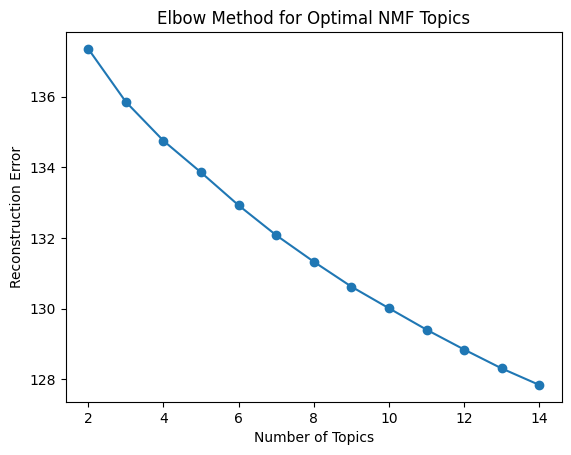

In [40]:
errors = []
topic_range = range(2, 15)

for k in topic_range:
    nmf_model = NMF(n_components=k, random_state=42)
    nmf_model.fit(tfidf)
    errors.append(nmf_model.reconstruction_err_)

# Plot
plt.plot(topic_range, errors, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Reconstruction Error")
plt.title("Elbow Method for Optimal NMF Topics")
plt.show()

In [43]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state = 40) #write your code here

In [44]:

W = nmf_model.fit_transform(tfidf)  # Document-topic matrix
print(pd.DataFrame(W.shape))
H = nmf_model.components_            # Topic-word matrix
print(pd.DataFrame(H.shape))

       0
0  21072
1      5
      0
0     5
1  7002


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



In [45]:
def display_topics(H, feature_names, top_words=10):
    for topic_idx, topic in enumerate(H):
        top_features = [feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_features)}")

display_topics(H, feature_names)

Topic #1: account, check, bank, money, chase, fund, deposit, branch, day, checking
Topic #2: card, charge, chase, credit, dispute, fee, transaction, purchase, service, fraud
Topic #3: loan, mortgage, chase, home, modification, property, year, letter, time, document
Topic #4: credit, report, inquiry, card, account, score, company, debt, information, reporting
Topic #5: payment, balance, month, fee, statement, day, time, auto, chase, date


In [46]:
#Print the Top15 words for each of the topics
words = np.array(tfidf_vectorizer.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i+1}' for i in range(num_topics)],
                           columns = [f'Word {i+1}' for i in range(15)]).astype(str)
for i in range(num_topics):
  ix = H[i].argsort()[::-1][:15]
  topic_words.iloc[i] = words[ix]
topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,chase,fund,deposit,branch,day,checking,transaction,number,business,claim,transfer
Topic 2,card,charge,chase,credit,dispute,fee,transaction,purchase,service,fraud,merchant,balance,time,company,claim
Topic 3,loan,mortgage,chase,home,modification,property,year,letter,time,document,rate,foreclosure,house,sale,request
Topic 4,credit,report,inquiry,card,account,score,company,debt,information,reporting,chase,identity,application,limit,bureau
Topic 5,payment,balance,month,fee,statement,day,time,auto,chase,date,credit,account,year,mortgage,car


In [47]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_names = {
    0: 'Bank Account services',
    1: 'Credit card',
    2: 'Theft/Dispute Reporting',
    3: 'Mortgage/Loan',
    4: 'Others'
}

# Created topic names as well based on the top 15 words per topic

In [49]:
W.shape

(21072, 5)

In [50]:
#Assign the best topic to each of the cmplaints in Topic Column
print(df_clean.shape)
df_clean['Topic'] =  W.argmax(axis=1)
# df_clean['Topic_Name'] = df_clean['Topic'].apply(topic_names) #write your code to assign topics to each rows.
df_clean['Topic_Name'] = df_clean['Topic'].map(topic_names)
print(df_clean.shape)

(21072, 6)
(21072, 8)


In [51]:
df_clean.head()

,complaint,complaint_nn_lemmatized,complaint_POS_removed,complaint_length,complaint_length_nn_only,Complaint_clean,Topic,Topic_Name
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account thank in advance for your help,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account advance help,439,133,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account advance help,2,Theft/Dispute Reporting
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead I,card agent anniversary date agent information order account change anniversary date consent recording agent mislead,296,115,card agent anniversary date agent information order account change anniversary date consent recording agent mislead,1,Credit card
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant,209,80,chase card report application identity consent service credit identity applicant,3,Mortgage/Loan
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to corr

In [52]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaint,complaint_nn_lemmatized,complaint_POS_removed,complaint_length,complaint_length_nn_only,Complaint_clean,Topic,Topic_Name
30199,chase bank is advertising a bonus for opening a checking account on the website it says open account and coupon code automatically applied the site also indicate that i should receive my bonus for opening an account within days i called chase and asked where was the bonus and was told it if i didnt have a coupon code that its too late to receive the bonus i went inside a branch to talk to a representative and got the same result i called customer service again and was told to create another account to receive the bonus i knew that was incorrect so i asked to speak to a manager who was rude and condescending the manager was not apologetic about me receiving the incorrect information i think chase is misleading consumers to sign up for an account and not give the bonus i could have opened an account with but i chose chase because they used to have good customer service and wanted the bonus i have documents to show the what information that the website is providing that proves i have been mislead it clearly states the bonus coupon code will be automatically applied when opening an account online which i did,chase bank be advertise a bonus for open a check account on the website it say open account and coupon code automatically apply the site also indicate that I should receive my bonus for open an account within day I call chase and ask where be the bonus and be tell it if I do not have a coupon code that its too late to receive the bonus I go inside a branch to talk to a representative and get the same result I call customer service again and be tell to create another account to receive the bonus I know that be incorrect so I ask to speak to a manager who be rude and condescend the manager be not apologetic about I receive the incorrect information I think chase be mislead consumer to sign up for an account and not give the bonus I could have open an account with but I choose chase because they use to have good customer service and want the bonus I have document to show the what information that the website be provide that prove I have be mislead it clearly state the bonus coupon code will be automatically apply when open an account online which I do,bonus check account website account coupon code site bonus account day chase bonus coupon code bonus branch representative result customer service account bonus manager manager information chase mislead consumer account bonus account chase customer service bonus document information website prove bonus coupon code account,1121,323,bonus check account website account coupon code site bonus account day chase bonus coupon code bonus branch representative result customer service account bonus manager manager information chase mislead consumer account bonus account chase customer service bonus document information website prove bonus coupon code account,0,Bank Account services
21088,a check deposit of was made to my checking account on the morning of a hold was then placed on the funds and they were not made available in a reasonable amount of time today is and the entirety of the check is still on hold it has been seven business days and nine calendar days i have called both banks and no help or insight as to why my funds are being held has been provided,a check deposit of be make to my checking account on the morning of a hold be then place on the fund and they be not make available in a reasonable amount of time today be and the entirety of the check be still on hold it have be seven business day and nine calendar day I have call both bank and no help or insight as to why my fund be be hold have be provide,check deposit checking account morning hold place fund amount time today entirety check hold business day calendar day bank help insight fund hold,379,146,check deposit checking account morning hold place fund amount time today entirety check hold

In [53]:
df_clean.dtypes

,0
complaint,object
complaint_nn_lemmatized,object
complaint_POS_removed,object
complaint_length,int64
complaint_length_nn_only,int64
Complaint_clean,object
Topic,int64
Topic_Name,object


In [54]:
df_clean['Topic'] = df_clean['Topic'].astype('int64')
print(df_clean.shape)

(21072, 8)


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [55]:
#Create the dictionary of Topic names and Topics

df_clean.head(2)

,complaint,complaint_nn_lemmatized,complaint_POS_removed,complaint_length,complaint_length_nn_only,Complaint_clean,Topic,Topic_Name
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account thank in advance for your help,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account advance help,439,133,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account advance help,2,Theft/Dispute Reporting
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead I,card agent anniversary date agent information order account change anniversary date consent recording agent mislead,296,115,card agent anniversary date agent information order account change anniversary date consent recording agent mislead,1,Credit card


In [56]:
df_clean

,complaint,complaint_nn_lemmatized,complaint_POS_removed,complaint_length,complaint_length_nn_only,Complaint_clean,Topic,Topic_Name
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account thank in advance for your help,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account advance help,439,133,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account advance help,2,Theft/Dispute Reporting
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead I,card agent anniversary date agent information order account change anniversary date consent recording agent mislead,296,115,card agent anniversary date agent information order account change anniversary date consent recording agent mislead,1,Credit card
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant,209,80,chase card report application identity consent service credit identity applicant,3,Mortgage/Loan
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to corr

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [58]:
df.columns, df.shape, df_clean.shape, df_clean.columns

(Index(['complaint_id', 'complaint'], dtype='object'),
 (21072, 2),
 (21072, 8),
 Index(['complaint', 'complaint_nn_lemmatized', 'complaint_POS_removed',
        'complaint_length', 'complaint_length_nn_only', 'Complaint_clean',
        'Topic', 'Topic_Name'],
       dtype='object'))

In [59]:
df_clean.head(1)

,complaint,complaint_nn_lemmatized,complaint_POS_removed,complaint_length,complaint_length_nn_only,Complaint_clean,Topic,Topic_Name
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account thank in advance for your help,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account advance help,439,133,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account advance help,2,Theft/Dispute Reporting


In [61]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint', 'Topic']]
print(training_data.shape)

(21072, 2)


In [62]:
training_data

,complaint,Topic
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,2
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,3
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,3
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number claim number is with chase,0
...,...,...
78303,after being a chase card customer for well over a decade was offered multiple solicitations for acquiring new credit cards with chase all with bonus airline miles and hotel points was approved for all new cards with no annual fee for year after less than months with payment always paid as agreed chase closed all my cards one of my approved new cards was never activated but was sent to me chase has done harm to my credit has charged me an annual fee even though they cancelled my account failed to credit my points for both airlines and hotel failed to credit up to for enrollment and failed to credit airline charge as agreed upon,1
78309,on wednesday i called chas my visa credit card provider and asked how to make a claim under their purchase protection benefit on i purchased three high school textbooks for my year old daughter because she transferred to a new school all three books were damaged when a water bottle in her backpack broke the chase representative assured me the textbooks would be covered and instructed me to file a claim at i immediately went to the website and filed the claim including uploading all of the requested 

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [63]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

In [64]:

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(training_data['complaint'])


#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

y = training_data['Topic']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.15, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(17911, 33578) (3161, 33578) (17911,) (3161,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [67]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [69]:
# Write your code here to build any 3 models and evaluate them using the required metrics
def evaluate_models(model_list, X_train, X_test, y_train, y_test):
    # Binarize labels for ROC AUC if multiclass
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)

    for model in model_list:
        print(f"\n{'='*60}")
        print(f"Evaluating Model: {model.__class__.__name__}")
        print(f"{'='*60}")

        clf = OneVsRestClassifier(model)
        clf.fit(X_train, label_binarize(y_train, classes=classes))

        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        # Convert predictions back from binary to labels
        y_train_pred_labels = np.argmax(y_train_pred, axis=1)
        y_test_pred_labels = np.argmax(y_test_pred, axis=1)
        y_train_labels = np.argmax(label_binarize(y_train, classes=classes), axis=1)
        y_test_labels = np.argmax(y_test_bin, axis=1)

        # Train/Test Accuracy
        train_accuracy = np.mean(y_train_pred_labels == y_train_labels)
        test_accuracy = np.mean(y_test_pred_labels == y_test_labels)
        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Accuracy:  {test_accuracy:.4f}")

        # Classification Report
        print("\nClassification Report (Test):")
        print(classification_report(y_test_labels, y_test_pred_labels))

        # Confusion Matrix
        cm = confusion_matrix(y_test_labels, y_test_pred_labels)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
        plt.title(f"Confusion Matrix - {model.__class__.__name__}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # ROC-AUC Curve (Multiclass)
        y_score = clf.predict_proba(X_test)
        fpr = {}
        tpr = {}
        roc_auc = {}

        for i in range(len(classes)):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(8, 6))
        for i in range(len(classes)):
            plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC AUC Curve - {model.__class__.__name__}")
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()


Evaluating Model: RandomForestClassifier
Train Accuracy: 1.0000
Test Accuracy:  0.6261

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.42      0.99      0.59       837
           1       0.97      0.63      0.77       930
           2       0.97      0.59      0.73       578
           3       0.99      0.39      0.56       459
           4       0.95      0.12      0.21       357

    accuracy                           0.63      3161
   macro avg       0.86      0.54      0.57      3161
weighted avg       0.83      0.63      0.62      3161



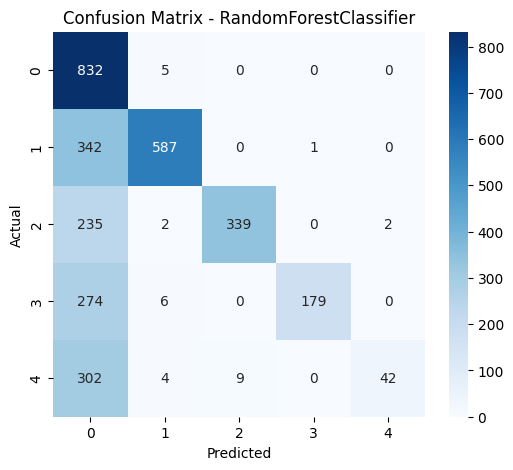

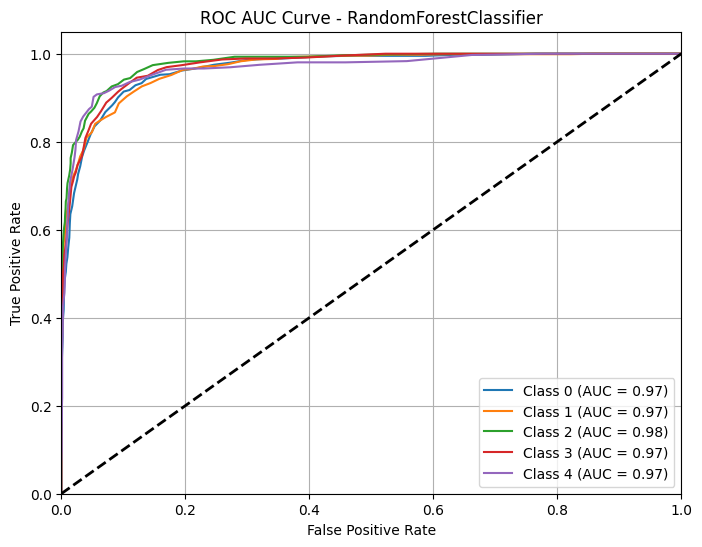


Evaluating Model: MultinomialNB
Train Accuracy: 0.3637
Test Accuracy:  0.3451

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.29      1.00      0.45       837
           1       0.96      0.20      0.33       930
           2       0.98      0.10      0.17       578
           3       1.00      0.04      0.08       459
           4       0.00      0.00      0.00       357

    accuracy                           0.35      3161
   macro avg       0.65      0.27      0.21      3161
weighted avg       0.68      0.35      0.26      3161



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



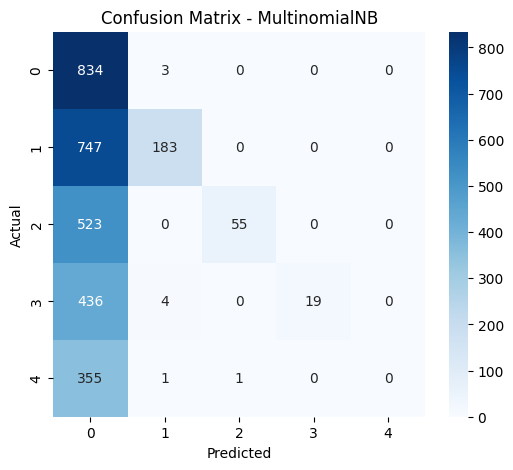

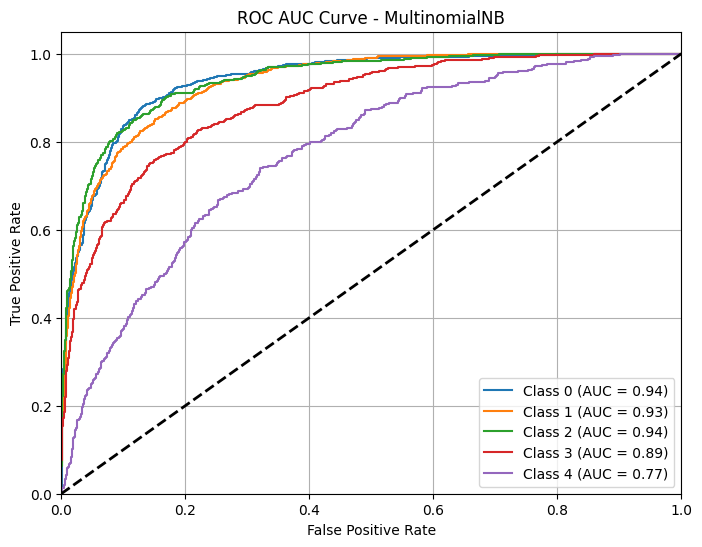


Evaluating Model: XGBClassifier


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[12:03:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[12:04:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[12:04:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[12:05:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[12:06:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Train Accuracy: 0.9954
Test Accuracy:  0.8826

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.77      0.96      0.85       837
           1       0.93      0.89      0.91       930
           2       0.95      0.88      0.91       578
           3       0.95      0.78      0.86       459
           4       0.94      0.82      0.88       357

    accuracy                           0.88      3161
   macro avg       0.91      0.87      0.88      3161
weighted avg       0.89      0.88      0.88      3161



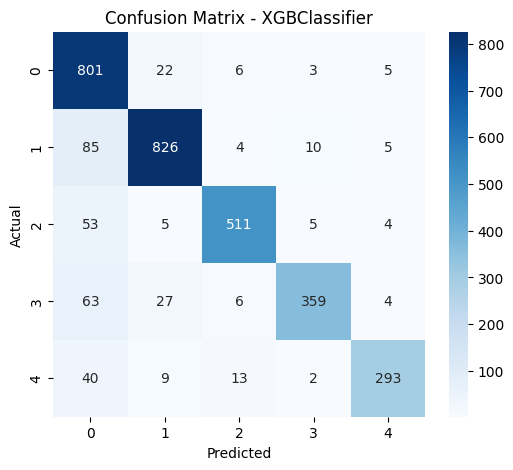

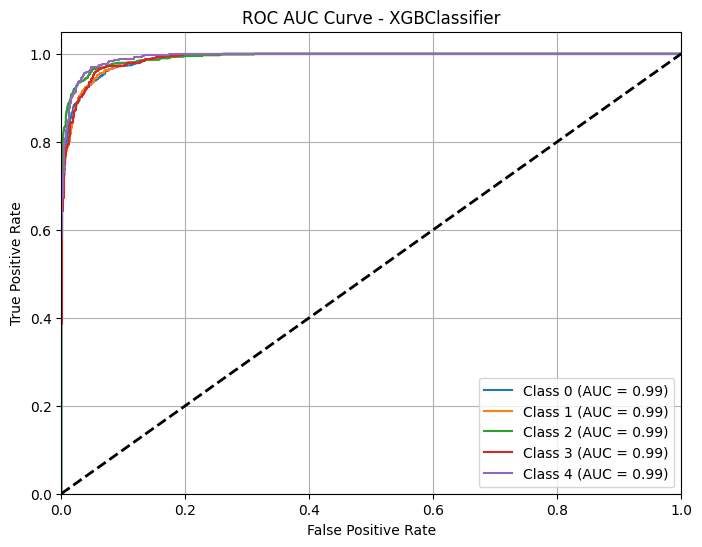

In [70]:
models = [
    RandomForestClassifier(n_estimators=100, random_state=42),
    MultinomialNB(),
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
]

evaluate_models(models, X_train, X_test, y_train, y_test)

## As we can see from here, the XGBoost model performs the best given the current data set. Therefore, it is better to proceed with this model. Also, showing the highest area under the ROC_AUC Curve. Obviously for more improvement, we can go with Hyperparameter tuning with the finalized XGB model to see if we can go even better, however, these results are already pretty good in terms of numbers. In business sense, real world scenario, around 70% accuracy with good precision and recall balance would be a good model.

#### Additional steps which can improvise the model:
1. There were lot of words observed in the tfidf matrix, which were spelled incorrectly, or were combination of multiple words. If we correct them before topic modeling or during model training we can get better results.
2. In the code file, there was only a requirement for showing bigrams and trigrams. However, if we had incorporated these to the data, then we can find better topics to understand real essence of the problem